# Project 2

##### import needed packages

In [194]:
# from tqdm import tqdm_notebook, tqdm
from collections import defaultdict,Counter
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from random import shuffle
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.nan)

# Classes and Functions

## Data Manipulation

### Cleaning and preprocessing

In [195]:
def preprocess(train_data, val_data, test_data, vocab_size=10000):
    
    # loop over all the given files
    for data in [train_data, val_data, test_data]:
        # contains a source and a target file
        for k,v in data.items():
            tokenized_path = v[:v.find('.')] + '_tokenized.{}'.format(k)

            # Tokenize 
            tokenize_command = 'perl tools/mosesdecoder/scripts/tokenizer/tokenizer.perl -l {lang} < {file_path} > {output_path}'.format(
                lang=k, file_path=v, output_path=tokenized_path)
            print('tokenize command:\t{}'.format(tokenize_command))
            
            # Lowercase
            lowercase_path = tokenized_path[:tokenized_path.find('.')] + '_lowercased.{}'.format(k)
            lowercase_command = 'perl tools/mosesdecoder/scripts/tokenizer/lowercase.perl < {file_path} > {output_path}'.format(
                file_path=tokenized_path, output_path=lowercase_path)
            print('lowercase command:\t{}\n'.format(lowercase_command))
            
    # BPE
    # Get vocabulary using train data
    script_name = 'python tools/subword-nmt/subword_nmt/learn_joint_bpe_and_vocab.py'
    args = ' --input {train_en} {train_fr} -s {num_symbols} -o {codes_file} --write-vocabulary {vocab_file}.en {vocab_file}.fr'
    substr_index = train_data['en'].find('/')
    vocab_file_name = train_data['en'][:substr_index] + '/vocab'
    codes_file_name = train_data['en'][:substr_index] + '/codes.bpe'
    learn_vocab_command = script_name + args.format(
        train_en='data/train/train_tokenized_lowercased.en',
        train_fr='data/train/train_tokenized_lowercased.fr',
        num_symbols=str(vocab_size),
        codes_file=codes_file_name,
        vocab_file=vocab_file_name
    )
    print('learn vocab command:\t{}'.format(learn_vocab_command))
    
    # Process all files the same way for consistency
    script_name = 'python tools/subword-nmt/subword_nmt/apply_bpe.py'
    for data in [train_data, val_data, test_data]:
        for k,v in data.items():
            args = ' -c {codes_file} --vocabulary {vocab_file}.{lang} --vocabulary-threshold 50 < {train_file}.{lang} > {train_file}_bpe.{lang}'
            train_file_name = v[:v.find('.')] + '_tokenized_lowercased'
            bpe_command = script_name + args.format(
                codes_file=codes_file_name,
                vocab_file=vocab_file_name,
                lang=k,
                train_file=train_file_name
            )
            print('bpe command:\t{}'.format(bpe_command))

### Building dictionaries and vocabularies

In [196]:
UNK = '<UNK>'
START = '<SOS>'
END = '<EOS>'
PAD = '<PAD>'

In [197]:
class DataProcessor():
    def __init__(self, file_name, vocab_size):
        self.max_sentence_length = -1
        self.vocab_size = vocab_size
        
        self.file_name = file_name
        self.sentences = self.load_data()
        self.vocab,self.vocab_size = self.build_vocab()
        self.w2i, self.i2w = self.build_dicts()        
        
    def load_data(self):
        sentences = []
        with open(self.file_name, 'r') as f:
            for raw_line in f:
                line = '{s} {l} {e}'.format(s=START, l=raw_line, e=END)
                sentences.append(line.split())                
        return sentences
    
    def build_dicts(self):
        """
        creates lookup tables to find the index given the word 
        and the otherway around 
        """
        w2i = defaultdict(lambda: w2i[UNK])# would something like this work? not entirely, needs some tweaking
        i2w = dict()
        for i,w in enumerate(self.vocab):
            i2w[i] = w
            w2i[w] = i
        return w2i, i2w    
    
    def build_vocab(self): 
        """
        builds a vocabulary with the most occuring words, in addition to
        the UNK token at index 0.
        START and END tokens are added to the vocabulary through the
        preprocessed sentences.
        with vocab size none, all existing words in the data are used
        """
        vocab = Counter()
        for s in self.sentences:
            l = len(s)
            if l > self.max_sentence_length:
                self.max_sentence_length = l
            for w in s:
                vocab[w] += 1

        vocab = [k for k,_ in vocab.most_common(self.vocab_size)]
        vocab = [UNK, PAD] + vocab
        return vocab,len(vocab)

### Getting data batches

In [198]:
def batch_generator(source_processor, target_processor, batch_size):
    idx = np.arange(len(source_processor.sentences))
    
    while True:
        shuffle(idx)
        batch_idx = [idx[i:i + batch_size] for i in range(0, len(idx) - (len(idx)%batch_size), batch_size)]
        
        for b_idx in batch_idx:
            b_words_source = np.zeros([batch_size, source_processor.max_sentence_length])
            b_positions_source = np.zeros([batch_size, source_processor.max_sentence_length])
            b_words_target = np.zeros([batch_size, target_processor.max_sentence_length])
            
            sentence_lengths_source = []
            sentence_lengths_target = []
            
            for i, bi in enumerate(b_idx):
                sent_source = source_processor.sentences[bi]
                sent_target = target_processor.sentences[bi]
                
                b_words_source[i, :len(sent_source)] = np.array([source_processor.w2i[w] for w in sent_source])
                b_positions_source[i, :len(sent_source)] = np.array([i for i in range(len(sent_source))])
                b_words_target[i, :len(sent_target)] = np.array([target_processor.w2i[w] for w in sent_target])
                
                sentence_lengths_source.append(len(sent_source))
                sentence_lengths_target.append(len(sent_target))
            
            yield (torch.from_numpy(b_words_source).type(torch.LongTensor),
                   torch.from_numpy(b_positions_source).type(torch.LongTensor),
                   torch.from_numpy(b_words_target).type(torch.LongTensor),
                   sentence_lengths_source,
                   sentence_lengths_target)

## Sequence 2 Sequence RNN's

### Encoders

In [199]:
class Encoder(nn.Module):
    def __init__(self, source_vocab_size, source_max_length, embeddings_dim):
        super().__init__()        
        self.word_embeddings = nn.Embedding(source_vocab_size, embeddings_dim)
        self.pos_embeddings = nn.Embedding(source_max_length, embeddings_dim)
        
    def forward(self, words_batch, pos_batch, sentence_lengths): # all inputs are tensors
        words_emb = self.word_embeddings(words_batch)
        pos_emb = self.pos_embeddings(pos_batch)
        full_emb = torch.add(words_emb,pos_emb)
        mean_emb = full_emb.sum(dim=1).float().div(sentence_lengths.view(-1,1)) # batched version of torch.mean(full_emb,1)
                                           
        return full_emb, mean_emb

### Decoders

In [210]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

class Decoder(nn.Module):
    def __init__(self, target_vocab_size, embeddings_dim, max_output_sentence_length, dropout_p=0.1): # embeddings is hidden, vocab size is output size
        super().__init__()
        
        self.embedding_dim = embedding_dims
        self.dropout_p = dropout_p
#         self.max_length = max_output_sentence_length
        
        self.target_embeddings = nn.Embedding(target_vocab_size, embeddings_dim)
        self.gru = nn.GRU(embeddings_dim*2, embeddings_dim, batch_first=True) # gru is an LSTM, and has 2 outputs
        self.dropout = nn.Dropout(self.dropout_p)
        self.out = nn.Linear(embeddings_dim, target_vocab_size)
        
    def forward(self, gold_words_batch, hidden_batch, stacked_encoded_words_batch):        
        batch_size = gold_words_batch.size(0)
        encoded_length = stacked_encoded_words_batch.size(1)
        
        emb = self.target_embeddings(gold_words_batch)
        emb = self.dropout(emb)
        
        # attention        
        alphas = torch.zeros(batch_size, encoded_length)
        alphas = hidden_batch.view(batch_size,1,self.embedding_dim).bmm(
            stacked_encoded_words_batch.view(batch_size,self.embedding_dim,encoded_length))
        
        # Turn to probability distribution
        alphas = F.softmax(alphas, dim=2)
                
        # context is weights x hidden states from encoder
        context = torch.bmm(alphas, stacked_encoded_words_batch)     
        
        # we have to concat context + emb        
        input = torch.cat((emb, context), 2)
        
        gru_output, hidden = self.gru(input, hidden_batch.view(1, batch_size, self.embedding_dim))
        
        output = self.out(gru_output)
        output = F.log_softmax(output, dim=1)
        
        return output, hidden

# Running the Code

## Define Hyper Parameters

#### files

In [201]:
# Raw
train_data = {'en': 'data/train/train.en', 'fr': 'data/train/train.fr'}
val_data = {'en': 'data/val/val.en', 'fr': 'data/val/val.fr'}
test_data = {'en': 'data/test/test_2017_flickr.en', 'fr': 'data/test/test_2017_flickr.fr'}

# Preprocessed
source_train_file = 'data/train/train_tokenized_lowercased_bpe.fr'
target_train_file = 'data/train/train_tokenized_lowercased_bpe.en'
source_val_file = 'data/val/val_tokenized_lowercased_bpe.fr'
target_val_file = 'data/val/val_tokenized_lowercased_bpe.en'
source_test_file = 'data/test/test_2017_flickr_tokenized_lowercased_bpe.fr'
target_test_file = 'data/test/test_2017_flickr_tokenized_lowercased_bpe.en'

#### Network Parameters

In [202]:
learning_rate = 1e-3
iterations = 1
batch_size = 16

source_vocab_size = 30000
target_vocab_size = 30000
hidden_dims = 128
embedding_dims = 128

## process data

perform the preprocessing

In [353]:
preprocess(train_data, val_data, test_data, source_vocab_size)

tokenize command:	perl tools/mosesdecoder/scripts/tokenizer/tokenizer.perl -l en < data/train/train.en > data/train/train_tokenized.en
lowercase command:	perl tools/mosesdecoder/scripts/tokenizer/lowercase.perl < data/train/train_tokenized.en > data/train/train_tokenized_lowercased.en

tokenize command:	perl tools/mosesdecoder/scripts/tokenizer/tokenizer.perl -l fr < data/train/train.fr > data/train/train_tokenized.fr
lowercase command:	perl tools/mosesdecoder/scripts/tokenizer/lowercase.perl < data/train/train_tokenized.fr > data/train/train_tokenized_lowercased.fr

tokenize command:	perl tools/mosesdecoder/scripts/tokenizer/tokenizer.perl -l en < data/val/val.en > data/val/val_tokenized.en
lowercase command:	perl tools/mosesdecoder/scripts/tokenizer/lowercase.perl < data/val/val_tokenized.en > data/val/val_tokenized_lowercased.en

tokenize command:	perl tools/mosesdecoder/scripts/tokenizer/tokenizer.perl -l fr < data/val/val.fr > data/val/val_tokenized.fr
lowercase command:	perl tool

prepare data for the model

In [203]:
source_processor = DataProcessor(source_train_file, source_vocab_size)
target_processor = DataProcessor(target_train_file, target_vocab_size)

## setup the Network

In [211]:
encoder = Encoder(source_processor.vocab_size,
                  source_processor.max_sentence_length, 
                  embeddings_dim=embedding_dims)
decoder = Decoder(target_processor.vocab_size, 
                  embeddings_dim=embedding_dims, 
                  max_output_sentence_length=target_processor.max_sentence_length)

opt_encoder = Adam(encoder.parameters(), lr=learning_rate)
opt_decoder = Adam(decoder.parameters(), lr=learning_rate)

## training

In [224]:
gen = batch_generator(source_processor, target_processor, batch_size)
losses = []

for it in range(iterations):    
    output = 0
    loss = nn.NLLLoss(ignore_index=target_processor.w2i[PAD])
    
    opt_encoder.zero_grad()
    opt_decoder.zero_grad()

    words_batch_source, pos_batch_source, words_batch_target, sentence_lengths_source, sentence_lengths_target = next(gen)
    
    # Encode
    all_embs, mean_emb = encoder(words_batch_source, pos_batch_source, torch.FloatTensor(sentence_lengths_source))

    # Decode
    hidden_state_batch = mean_emb
    
#     for w_idx in range(target_processor.max_sentence_length):
    for w_idx in range(max(sentence_lengths_target)):
        prediction, hidden_state_batch = decoder(
            words_batch_target[:,w_idx].view(-1,1), 
            hidden_state_batch,
            all_embs)
        
        output += loss(prediction.view(batch_size, target_processor.vocab_size), 
                       words_batch_target[:,w_idx])
    
    losses.append(output) # the loss is the average of losses, so divide over number of words in each sentence
    
    output.backward()

    opt_encoder.step()
    opt_decoder.step()
    
    
# TODO: Should we run until convergence on validation set? probably, if there is time

Plot losses

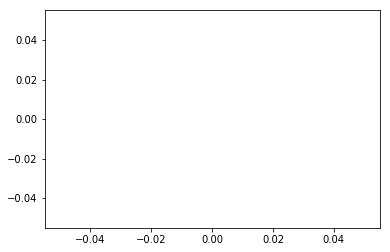

[tensor(0.)]

In [358]:
plt.plot(losses)
plt.show()
losses

## prediction

In [205]:
source_processor_test = DataProcessor(source_test_file, source_vocab_size) # TODO: This has to use all vocab
target_processor_test = DataProcessor(target_test_file, target_vocab_size) # TODO: This has to use all vocab

In [225]:
predicted_sentences = []

for s in source_processor_test.sentences:
    words_tokens = torch.LongTensor([source_processor_test.w2i[w] for w in s])
    pos_tokens = torch.LongTensor([i for i in range(len(s))])
    
    # Encode
    all_embs, mean_emb = encoder(words_tokens.view(1, len(s)),
                                 pos_tokens.view(1, len(s)), 
                                 torch.FloatTensor([len(s)]))
    
    # Decode
    predicted_words = []
    
    start_token = torch.LongTensor([target_processor.w2i[START]])
    prediction = start_token.view(1,1)
    
    hidden_state_batch = mean_emb
    
    for w_idx in range(target_processor.max_sentence_length):# loop until EOS is produced or a max is reached (max_sentence_length)
        prediction, hidden_state_batch = decoder(
            prediction, # the previous prediction
            hidden_state_batch,
            all_embs)
        
        index_predicted_word = np.argmax(prediction.detach().numpy(), axis=2)[0][0]
        predicted_word = target_processor.i2w[index_predicted_word]
        predicted_words.append(predicted_word)
        
        if predicted_word == END:
            break
            
        prediction = torch.LongTensor([index_predicted_word]).view(1,1)
    
    predicted_sentences.append(predicted_words)
    
    break  ### TODO: Remove this to predict on the whole test set #################
    
print(predicted_sentences)

[['<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>']]


## Evaluation

In [ ]:
# Don't forget to do:
# sed -r 's/(@@ )|(@@ ?$)//g' 

### BLEU

### Meteor

### TER